In [1]:
# Native Python imports
import sys
import os
import time
import random
import math
import glob
import gc
from warnings import filterwarnings

# Standard vanilla pip libraries
import pandas as pd
import numpy as np
import cv2
import PIL.Image

# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR

# collection of Pytorch Image models
!pip install timm
import timm 

# Fancy imports
import albumentations
from tqdm.notebook import tqdm

# Plotting imports
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from pylab import rcParams
import seaborn as sns
%matplotlib inline

# Sklearn imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold

filterwarnings("ignore")
device = torch.device('cuda') 

In [2]:
# Setup seed for experiments
def seed_everything(seed):
    random.seed(seed) # python random seed
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    np.random.seed(seed) # numpy seed
    torch.manual_seed(seed) # torch seed
    torch.cuda.manual_seed(seed) # torch seed
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f'Setting all seeds to be {seed} to reproduce...')
    
seed_everything(42)



Setting all seeds to be 42 to reproduce...


In [4]:
# Dataset loader class
class SHOPEEDataset(Dataset):
    def __init__(self, df, mode, transform=None):
        
        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.loc[index] # get the row for this sample which contains all info
        img = cv2.imread(row.file_path) # read in image as numpy ndarray
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert opencv BGR color channel order to GB
        
        # Optional: If doing data augmentation
        if self.transform is not None:
            res = self.transform(image=img)
            img = res['image']
        
        img = img.astype(np.float32) # convert to float32 
        img = img.transpose(2,0,1) # put image channel into first dimension like 3x128x128
        
        # Finally convert to torch tensors
        
        # If running test set then just return the image, no labels
        if self.mode == 'test':
            return torch.tensor(img).float()
        else:
            # return both image and label, our label being the label_group number
            return torch.tensor(img).float(), torch.tensor(row.label_group).float()



In [5]:
# Setup model
class ArcModule(nn.Module):
    def __init__(self, in_features, out_features, s=10, m=0.5):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_normal_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        
        self.th = torch.tensor(math.cos(math.pi - m))
        self.mm = torch.tensor(math.sin(math.pi - m) * m)

    def forward(self, inputs, labels):
        # Multiply inputs with normalized weights
        cos_th = F.linear(inputs, F.normalize(self.weight))
        
        # Clamp values from -1 to 1
        cos_th = cos_th.clamp(-1, 1)
        
        # Compute sine-theta term?
        sin_th = torch.sqrt(1.0 - torch.pow(cos_th, 2))
        
        # Some magic math
        cos_th_m = cos_th * self.cos_m - sin_th * self.sin_m
        # print(type(cos_th), type(self.th), type(cos_th_m), type(self.mm))
        
        
        cos_th_m = torch.where(cos_th > self.th, cos_th_m, cos_th - self.mm)
        
        # compute indices for this condition
        cond_v = cos_th - self.th
        cond = cond_v <= 0
        
        # perform computation on these specific indices
        cos_th_m[cond] = (cos_th - self.mm)[cond]
        
        # if single label, add another dimension for pytorch
        if labels.dim() == 1:
            labels = labels.unsqueeze(-1)
            
        
        onehot = torch.zeros(cos_th.size()).cuda()
        
        labels = labels.type(torch.LongTensor).cuda()
        
        # 
        onehot.scatter_(1, labels, 1.0)
        
        outputs = onehot * cos_th_m + (1.0 - onehot) * cos_th
        
        outputs = outputs * self.s
        
        return outputs
    
class SHOPEEDenseNet(nn.Module):

    def __init__(self, channel_size, out_feature, dropout=0.5, backbone='densenet121', pretrained=False):
        super(SHOPEEDenseNet, self).__init__()
        self.backbone = timm.create_model(backbone, pretrained=pretrained)
        self.channel_size = channel_size
        self.out_feature = out_feature
        self.in_features = self.backbone.classifier.in_features
        self.margin = ArcModule(in_features=self.channel_size, out_features = self.out_feature)
        self.bn1 = nn.BatchNorm2d(self.in_features)
        self.dropout = nn.Dropout2d(dropout, inplace=True)
        self.fc1 = nn.Linear(self.in_features * 16 * 16 , self.channel_size)
        self.bn2 = nn.BatchNorm1d(self.channel_size)
        
    def forward(self, x, labels=None):
        features = self.backbone.features(x)
        features = self.bn1(features)
        features = self.dropout(features)
        features = features.view(features.size(0), -1)
        features = self.fc1(features)
        features = self.bn2(features)
        features = F.normalize(features)
        if labels is not None:
            return self.margin(features, labels)
        return features



In [6]:
# load training data
data_dir = 'input/shopee-product-matching/train_images'
df_train = pd.read_csv('input/shopee-product-matching/train.csv')

# add filepath as dataframe member
df_train['file_path'] = df_train.image.apply(lambda x: os.path.join(data_dir, x))


# Create Cross-validation folds
gkf = GroupKFold(n_splits=5)
df_train['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(gkf.split(df_train, None, df_train.label_group)):
    df_train.loc[valid_idx, 'fold'] = fold
    
# Prep labels to be from 0 to N-1 groups
le = LabelEncoder()
df_train.label_group = le.fit_transform(df_train.label_group)

In [7]:
image_size = 512

# Data augmentation transformers
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
    albumentations.HueSaturationValue(p=0.5, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
    albumentations.ShiftScaleRotate(p=0.5, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
    albumentations.CoarseDropout(p=0.5),
    albumentations.Normalize()
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.Normalize()
])

In [8]:
# Create the dataset from dataframe
dataset = SHOPEEDataset(df_train, 'train', transform = transforms_train)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

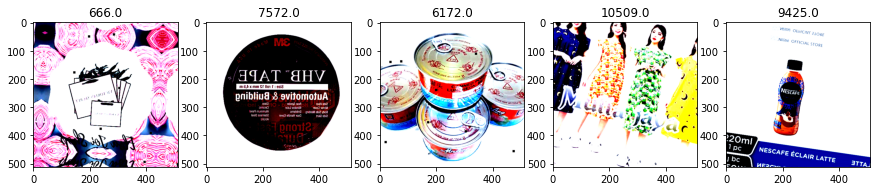

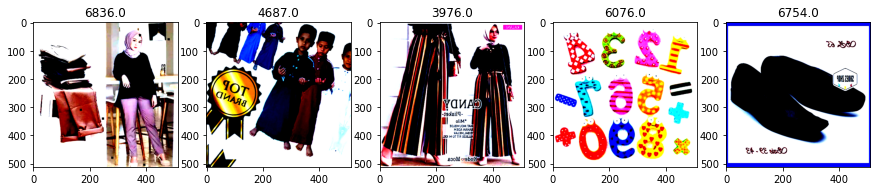

In [9]:
# Plot some sample images and their label
rcParams['figure.figsize'] = 15,5
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = i*5 + p
        img, label = dataset[idx]
        axarr[p].imshow(img.transpose(0,1).transpose(1,2).squeeze())
        axarr[p].set_title(label.item())

In [10]:
# Configurations
batch_size = 16
n_worker = 4
init_lr = 3e-4
n_epochs = 25 # from my experiments, use > 25 when margin = 0.5
fold_id = 0
holdout_id = 0
valid_every = 5
save_after = 10
accumulation_step = 1
margin = 0.5 # 0 for faster convergence, larger may be beneficial
search_space = np.arange(40, 100, 10) # in my experiments, thresholds should be between 40 - 90 (/100) for cosine similarity
use_amp = False # todo: figure how to work with pytorch native amp
debug = False # set this to False to train in full
kernel_type = 'baseline'
model_dir = 'weights/'
data_dir = 'input/shopee-product-matching/train_images'
#!mkdir $model_dir

In [12]:
# Create model
model = SHOPEEDenseNet(image_size, df_train.label_group.nunique())
model.to(device);

In [13]:
# Setup dataloaders for training

# Split training set and validation set
df_train_this = df_train[df_train['fold'] != fold_id]
df_valid_this = df_train[df_train['fold'] == fold_id]

# Added a count of each class to the validation dataframe
df_valid_this['count'] = df_valid_this.label_group.map(df_valid_this.label_group.value_counts().to_dict())

# Dataset loaders for training and validation
dataset_train = SHOPEEDataset(df_train_this, 'train', transform = transforms_train)
dataset_valid = SHOPEEDataset(df_valid_this, 'test', transform = transforms_valid)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers = n_worker)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers = n_worker)

In [14]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = init_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

In [ ]:
# Actual training loop
for epoch in range(n_epochs):
    
    scheduler.step()

    # ----------------
    model.train()
    bar = tqdm(train_loader)
    
    if use_amp:
        scaler = torch.cuda.amp.GradScaler()
        
    losses = []
    for batch_idx, (images, targets) in enumerate(bar):
        
        # Put on GPU
        images, targets = images.to(device), targets.to(device).long()
        
        if debug and batch_idx == 100:
            print('Debug Mode. Only train on first 100 batches.')
            break
        
        # Automated Mixed Precision
        if use_amp:
            with torch.cuda.amp.autocast():
                
                # forward pass
                logits = model(images, targets)
                
                # compute loss
                loss = criterion(logits, targets)
            
            scaler.scale(loss).backward()
            
            if ((batch_idx + 1) %  accumulation_step == 0) or ((batch_idx + 1) == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
        else:
            
            # forward pass
            logits = model(images, targets)
            
            # compute loss
            loss = criterion(logits, targets)
            
            # backward pass and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # track losses for this batch
        losses.append(loss.item())
        smooth_loss = np.mean(losses[-30:])

        bar.set_description(f'loss: {loss.item():.5f}, smth: {smooth_loss:.5f}')

    loss_train = np.mean(losses)
    
    # ---------------------
    
    
    if epoch % valid_every == 0: 
        
        # Every some number of epochs
        
        print('Now generating features for the validation set to simulate the submission.')
        FEAS = generate_test_features(valid_loader)
        
        FEAS = torch.tensor(FEAS).cuda()
        
        print('Finding Best Threshold in the given search space.')
        find_threshold(df = df_valid_this, 
               lower_count_thresh = 0, 
               upper_count_thresh = 999,
               search_space = search_space)

        if epoch >= save_after:
            # save model every so often
            torch.save(model.state_dict(), f'{model_dir}{kernel_type}_fold{fold_id}_densenet_{image_size}_epoch{epoch}.pth')

  0%|          | 0/1713 [00:00<?, ?it/s]